# Sales order data exploration
Use this notebook to explore sales order data


In [4]:
from pyspark.sql.types import *

orderSchema = StructType([
     StructField("SalesOrderNumber", StringType()),
     StructField("SalesOrderLineNumber", IntegerType()),
     StructField("OrderDate", DateType()),
     StructField("CustomerName", StringType()),
     StructField("Email", StringType()),
     StructField("Item", StringType()),
     StructField("Quantity", IntegerType()),
     StructField("UnitPrice", FloatType()),
     StructField("Tax", FloatType())
 ])

df = spark.read.format("csv").schema(orderSchema).load("Files/orders/*.csv")

display(df)

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 6, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 59dc3b2d-49ae-417c-88ad-dfdb9c409023)

In [5]:
customers = df.select("CustomerName", "Email").where(df['Item']=='Road-150 Red, 52')

print(customers.count())
print(customers.distinct().count())

display(customers.distinct())

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 7, Finished, Available, Finished)

302
302


SynapseWidget(Synapse.DataFrame, 8518c73d-bed3-4c5c-b360-3c525fa32b82)

In [6]:
productSales = df.select("Item", "Quantity").groupBy("Item").sum()

display(productSales)

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 2e077380-aa78-47c2-b7be-40189b6df2fc)

In [7]:
from pyspark.sql.functions import *

yearlySales = df.select(year(col("OrderDate")).alias("Year")).groupBy("Year").count().orderBy("Year")

display(yearlySales)

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 9, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 58c3c7b4-beae-4156-a6dd-d6b84db1c77e)

In [8]:
from pyspark.sql.functions import *

# Create Year and Month columns
transformed_df = df.withColumn("Year", year(col("OrderDate"))).withColumn("Month", month(col("OrderDate")))

# Create the new FirstName and LastName fields
transformed_df = transformed_df.withColumn("FirstName", split(col("CustomerName"), " ").getItem(0)).withColumn("LastName", split(col("CustomerName"), " ").getItem(1))

# Filter and reorder columns
transformed_df = transformed_df["SalesOrderNumber", "SalesOrderLineNumber", "OrderDate", "Year", "Month", "FirstName", "LastName", "Email", "Item", "Quantity", "UnitPrice", "Tax"]

# Display the first five orders
display(transformed_df.limit(5))

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 10, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 5a9d0712-b28b-4242-8e8b-f8ef81ee9975)

In [9]:
transformed_df.write.mode("overwrite").parquet('Files/transformed_data/orders')

print ("Transformed data saved!")

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 11, Finished, Available, Finished)

Transformed data saved!


In [11]:
orders_df = spark.read.format("parquet").load("Files/transformed_data/orders")
display(orders_df)

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 13, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c83596da-d10c-4e99-ae27-0575cb59f54e)

In [12]:
orders_df.write.partitionBy("Year","Month").mode("overwrite").parquet("Files/partitioned_data")

print ("Transformed data saved!")

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 14, Finished, Available, Finished)

Transformed data saved!


In [13]:
orders_2021_df = spark.read.format("parquet").load("Files/partitioned_data/Year=2021/Month=*")

display(orders_2021_df)

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 15, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 1c4c97e0-8ee5-426b-8d22-ad47053afaf5)

In [14]:
# Create a new table
df.write.format("delta").saveAsTable("salesorders")

# Get the table description
spark.sql("DESCRIBE EXTENDED salesorders").show(truncate=False)

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 16, Finished, Available, Finished)

+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                                                                            |comment|
+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------+-------+
|SalesOrderNumber            |string                                                                                                                               |NULL   |
|SalesOrderLineNumber        |int                                                                                                                                  |NULL   |
|OrderDate                   |date                                                                                                     

In [15]:
df = spark.sql("SELECT * FROM lakehouse002.salesorders LIMIT 1000")
display(df)

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 17, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, bd8e329f-3157-4bce-8e6f-49b9cfae90d8)

In [16]:
 %%sql
 SELECT YEAR(OrderDate) AS OrderYear,
        SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
 FROM salesorders
 GROUP BY YEAR(OrderDate)
 ORDER BY OrderYear;

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 18, Finished, Available, Finished)

<Spark SQL result set with 3 rows and 2 fields>

In [17]:
 %%sql
 SELECT * FROM salesorders

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 19, Finished, Available, Finished)

<Spark SQL result set with 1000 rows and 9 fields>

In [18]:
 sqlQuery = "SELECT CAST(YEAR(OrderDate) AS CHAR(4)) AS OrderYear, \
                 SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue \
             FROM salesorders \
             GROUP BY CAST(YEAR(OrderDate) AS CHAR(4)) \
             ORDER BY OrderYear"
 df_spark = spark.sql(sqlQuery)
 df_spark.show()

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 20, Finished, Available, Finished)

+---------+--------------------+
|OrderYear|        GrossRevenue|
+---------+--------------------+
|     2019|   4172169.969970703|
|     2020|   6882259.268127441|
|     2021|1.1547835291696548E7|
+---------+--------------------+



StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 28, Finished, Available, Finished)

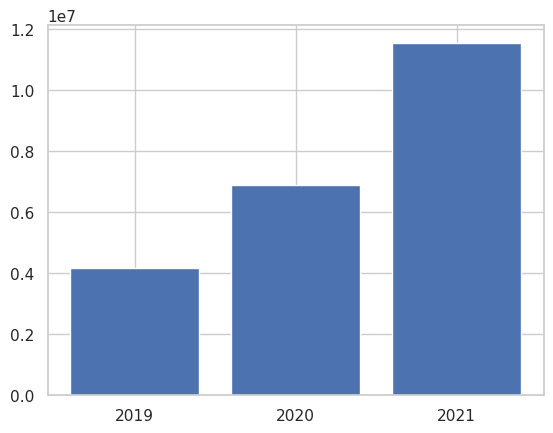

In [26]:
 from matplotlib import pyplot as plt

 # matplotlib requires a Pandas dataframe, not a Spark one
 df_sales = df_spark.toPandas()

 # Create a bar plot of revenue by year
 plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'])

 # Display the plot
 plt.show()

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 29, Finished, Available, Finished)

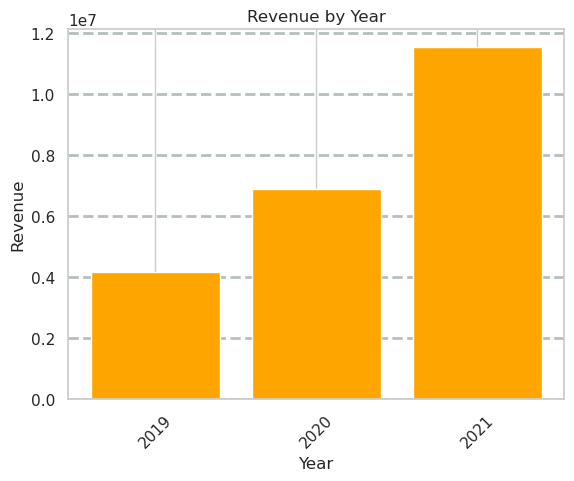

In [27]:
from matplotlib import pyplot as plt

# Clear the plot area
plt.clf()

# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')

# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)

# Show the figure
plt.show()

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 30, Finished, Available, Finished)

<Figure size 640x480 with 0 Axes>

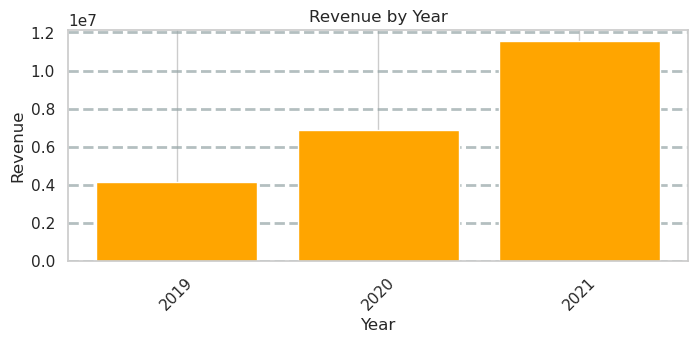

In [28]:
 from matplotlib import pyplot as plt

 # Clear the plot area
 plt.clf()

 # Create a Figure
 fig = plt.figure(figsize=(8,3))

 # Create a bar plot of revenue by year
 plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')

 # Customize the chart
 plt.title('Revenue by Year')
 plt.xlabel('Year')
 plt.ylabel('Revenue')
 plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
 plt.xticks(rotation=45)

 # Show the figure
 plt.show()

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 24, Finished, Available, Finished)

<Figure size 640x480 with 0 Axes>

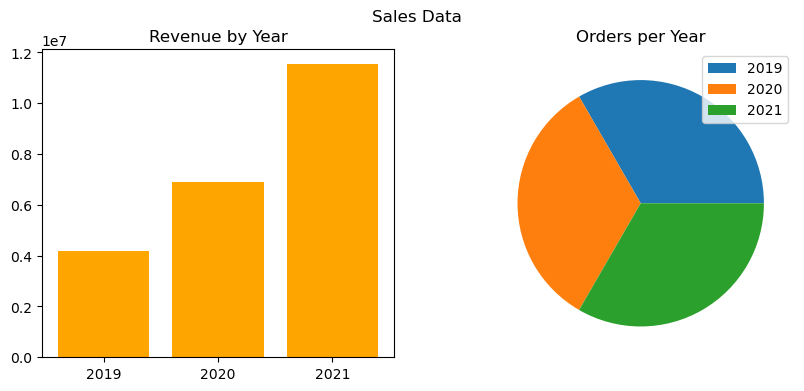

In [22]:
 from matplotlib import pyplot as plt

 # Clear the plot area
 plt.clf()

 # Create a figure for 2 subplots (1 row, 2 columns)
 fig, ax = plt.subplots(1, 2, figsize = (10,4))

 # Create a bar plot of revenue by year on the first axis
 ax[0].bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')
 ax[0].set_title('Revenue by Year')

 # Create a pie chart of yearly order counts on the second axis
 yearly_counts = df_sales['OrderYear'].value_counts()
 ax[1].pie(yearly_counts)
 ax[1].set_title('Orders per Year')
 ax[1].legend(yearly_counts.keys().tolist())

 # Add a title to the Figure
 fig.suptitle('Sales Data')

 # Show the figure
 plt.show()

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 31, Finished, Available, Finished)

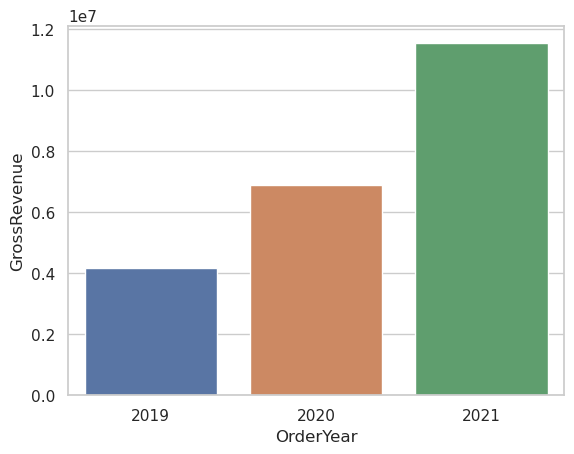

In [29]:
 import seaborn as sns

 # Clear the plot area
 plt.clf()

 # Create a bar chart
 ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)

 plt.show()

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 32, Finished, Available, Finished)

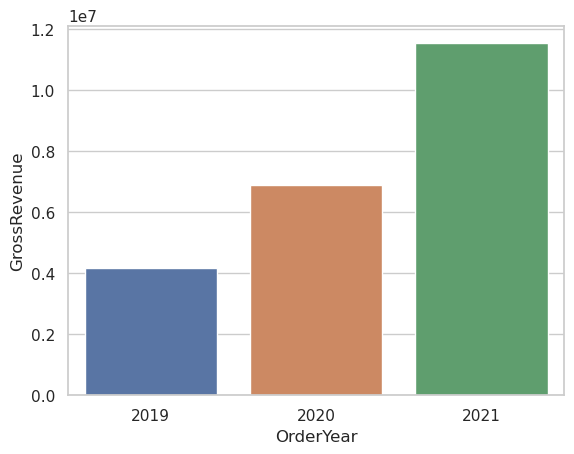

In [30]:
 import seaborn as sns

 # Clear the plot area
 plt.clf()

 # Set the visual theme for seaborn
 sns.set_theme(style="whitegrid")

 # Create a bar chart
 ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)

 plt.show()

StatementMeta(, 3bf8e589-e2ba-4fb9-b4db-891a9bd3a9a4, 27, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


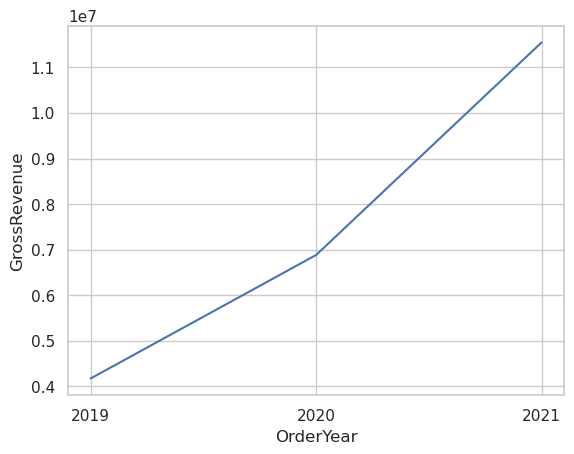

In [25]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Create a line chart
ax = sns.lineplot(x="OrderYear", y="GrossRevenue", data=df_sales)

plt.show()